# 1. load functions

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from scipy.stats import zscore, pearsonr, kendalltau,  entropy, spearmanr, linregress, rankdata, ttest_rel, ttest_1samp, ttest_ind, zscore, sem
from statsmodels.stats.multitest import multipletests, fdrcorrection
from nltools.external import glover_hrf
from itertools import permutations, combinations, product

In [227]:
MASKDIR = '/home/jiunchoi/OFD/source/'
DATADIR = '/home/jiunchoi/OFD/OFD_DATA/derivatives/'

def get_boundary2(group,sub,run):
    groupsub = '0'+str(group)+'0'+str(sub)
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-0{group}/sub-{groupsub}_run-{run}_day2_words.xlsx')
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{group}/sub-{groupsub}_day2_posthoc.xlsx')
    # word_data.keys() = start, end, word
    # posthoc_data.keys() = sentence, segmentation, description, tag
    words = word_data['word']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []
    endidx = [0]
    for t in range (len(posthoc_data['Unnamed: 0'])-1):
        if posthoc_data['Unnamed: 0'][t]+1 != posthoc_data['Unnamed: 0'][t+1]:
            endidx.append(t)
    endidx.append(len(posthoc_data['Unnamed: 0'])-1)
    if len(endidx)>2:
        segcol = np.array(posthoc_data['segmentation'][endidx[run-1]+1:endidx[run]+1])
    else:
        segcol = np.array(posthoc_data['segmentation'])
    tmpstart = start[0]
    for i in range (len(words)-1):
        if '.' in str(words[i]) or ',' in str(words[i]) or '었고' in str(words[i]) or '것 같고' in str(words[i]) or '지고' in str(words[i]) or '는데' in str(words[i]) or '근데' in str(words[i]) or '그리고' in str(words[i]) or '그러고' in str(words[i]) or '됐고' in str(words[i]) or '했고' in str(words[i]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])
    # working for subs with only 1 run
    tmpstart = sentstartend[0][0]
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:     
            tmpend = sentstartend[i][1]     
            eventstartend.append([tmpstart,tmpend])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[len(segcol)-1][1]
    eventstartend.append([tmpstart,tmpend]) 
    return np.array(eventstartend)

def read_subnames(group):
    with open(f'/home/jiunchoi/OFD/OFD_BHV_clean/subnames', 'r') as file:
        lines = file.readlines()
        line = lines[group - 1].replace('\n','')
        subnames = line.split(' ')[1:]
        return subnames
    
def get_boundary3(group,sub,run):
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-0{group}/group-0{group}_day1_words.xlsx')
    subnames = read_subnames(group)
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{group}/group-0{group}_day1_posthoc_{subnames[sub-1]}님.xlsx')
    # word_data.keys() = speaker,start, end, word
    # posthoc_data.keys() = speaker,sentence, segmentation, description, emotion,subname의몰입도
    words = word_data['word']
    speaker = word_data['speaker']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []
    endidx = [0]
    for t in range (len(posthoc_data['Unnamed: 0'])-1):
        if posthoc_data['Unnamed: 0'][t]+1 != posthoc_data['Unnamed: 0'][t+1]:
            endidx.append(t)
    endidx.append(len(posthoc_data['Unnamed: 0'])-1)
    if len(endidx)>2:
        segcol = np.array(posthoc_data['segmentation'][endidx[run-1]+1:endidx[run]+1])
    else:
        segcol = np.array(posthoc_data['segmentation'])

    tmpstart = start[0]
    for i in range (len(words)-1):
        if int(speaker[i]) != int(speaker[i+1]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])

    # working for subs with only 1 run
    tmpstart = sentstartend[0][0]
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:     
            tmpend = sentstartend[i][1]     
            eventstartend.append([tmpstart,tmpend])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[len(segcol)-1][1]
    eventstartend.append([tmpstart,tmpend]) 
    return np.array(eventstartend)

mask = nib.load(f'{MASKDIR}DMN_HIPP_mask.nii.gz').get_fdata()
atlas = np.array(nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata())
roilist = {'AG':[4,14], 'RSC':[12,23], 'PMC':[13,24], 'dmPFC':[9,21], 'HP':[215,216,217,218]}

def load_epi_mask(groupsub, run, key):
    fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_RECALL_{run}_sc_dt_sm.nii.gz').get_fdata()
    epi_parcels = []
    for i in roilist[key]:
        if key=='HP':
            epi_parcel = np.nanmean(fmri_data[atlas==i],axis=0).T # time,vox
        else:
            epi_parcel = np.nanmean(fmri_data[mask==i],axis=0).T # time,vox
        epi_parcel = zscore(epi_parcel, axis=0)
        epi_parcel = np.nan_to_num(epi_parcel)
        epi_parcels.append(epi_parcel)
    epi_parcels = np.mean(np.array(epi_parcels),axis=0)
    return epi_parcels

# 2. RECALL

## 2.1. load data

In [27]:
# brain
groups=[2,3,4,5]
group_brain = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        groupsub = f'0{group}0{sub}'
        sub_brain = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        elif (group==1 and sub==2):
            runs = [1,2]
        else:
            runs = [1]
        for run in runs:
            fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_RECALL_{run}_sc_dt_sm.nii.gz').get_fdata()
            fiverois = np.zeros((5,len(fmri_data[0,0,0,:])))
            for idx, key in enumerate(list(roilist.keys())):
                epi_parcels = []
                for i in roilist[key]:
                    if key=='HP':
                        epi_parcel = np.nanmean(fmri_data[atlas==i],axis=0).T # time,vox
                    else:
                        epi_parcel = np.nanmean(fmri_data[mask==i],axis=0).T # time,vox
                    epi_parcel = zscore(epi_parcel, axis=0)
                    epi_parcel = np.nan_to_num(epi_parcel)
                    epi_parcels.append(epi_parcel)
                epi_parcels = np.mean(np.array(epi_parcels),axis=0)
                fiverois[idx,:] = epi_parcels
            sub_brain.append(fiverois)
        group_brain[group-2,sub-1] = sub_brain

In [36]:
# event boundaries
group_boundaries = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        groupsub = f'0{group}0{sub}'
        sub_boundaries = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        elif (group==1 and sub==2):
            runs = [1,2]
        else:
            runs = [1]
        for run in runs:
            sub_boundaries.append(get_boundary2(group,sub,run))
        group_boundaries[group-2,sub-1] = sub_boundaries

## 2.2. load event boundaries

In [63]:
# boundary effects
w1 = 5
w2 = 15

roi_activity= {}


for roi,roikey in enumerate(list(roilist.keys())):
    group_activity = np.zeros((len(groups),3), dtype='object')
    for group in groups:
        for sub in [1,2,3]:
            sub_activities = []
            if (group==2 and sub==1):
                runs = [1,2,3]
            elif (group==1 and sub==2):
                runs = [1,2]
            else:
                runs = [1]
            for run in runs:
                evs = group_boundaries[group-2,sub-1][run-1][:,1]//1000
                epi = group_brain[group-2,sub-1][run-1][roi]
                prev = 0
                after = 0
                activity = []
                for e,ev in enumerate(evs):
                    after = ev-w1
                    if len(epi[ev-w1:ev+w2])==20:
                        if after > prev:
                            activity.append(epi[ev-w1:ev+w2])
                    prev=ev+w2
                sub_activities.append(np.array(activity))
            group_activity[group-2,sub-1] = sub_activities
    roi_activity[roikey] = group_activity


In [80]:
# boundary effects - control
w1 = 5
w2 = 15

roi_activity_random= {}


for roi,roikey in enumerate(list(roilist.keys())):
    group_activity = np.zeros((len(groups),3), dtype='object')
    for group in groups:
        for sub in [1,2,3]:
            sub_activities = []
            if (group==2 and sub==1):
                runs = [1,2,3]
            elif (group==1 and sub==2):
                runs = [1,2]
            else:
                runs = [1]
            for run in runs:
                nonevs = (np.mean(group_boundaries[group-2,sub-1][run-1],axis=1)//1000).astype('int')
                epi = group_brain[group-2,sub-1][run-1][roi]
                prev = 0
                after = 0
                activity = []
                for e,ev in enumerate(nonevs):
                    after = ev-w1
                    if len(epi[ev-w1:ev+w2])==20:
                        if after > prev:
                            activity.append(epi[ev-w1:ev+w2])
                    prev=ev+w2
                sub_activities.append(np.array(activity))
            group_activity[group-2,sub-1] = sub_activities
    roi_activity_random[roikey] = group_activity


In [106]:
roi_activity_concat = {}
roi_activity_random_concat = {}
for roi,roikey in enumerate(list(roilist.keys())):
    for group in groups:
        for sub in [1,2,3]:
            if (group==2 and sub==1):
                roi_act = roi_activity[roikey][group-2,sub-1][0]
                roi_actr = roi_activity_random[roikey][group-2,sub-1][0]
                runs = [1,2,3]
            elif (group==1 and sub==2):
                runs = [1,2]
            else:
                runs = [1]
            roi_act = np.vstack((roi_act,roi_activity[roikey][group-2,sub-1][0]))
            roi_actr = np.vstack((roi_actr,roi_activity_random[roikey][group-2,sub-1][0]))
            for run in runs[1:]:
                roi_act = np.vstack((roi_act,roi_activity[roikey][group-2,sub-1][run-1]))
                roi_actr = np.vstack((roi_actr,roi_activity_random[roikey][group-2,sub-1][run-1]))

    roi_activity_concat[roikey] = roi_act
    roi_activity_random_concat[roikey] = roi_actr

print(roi_activity_concat[roikey].shape, roi_activity_random_concat[roikey].shape)


(306, 20) (344, 20)


## 2.3. plot event boundaries

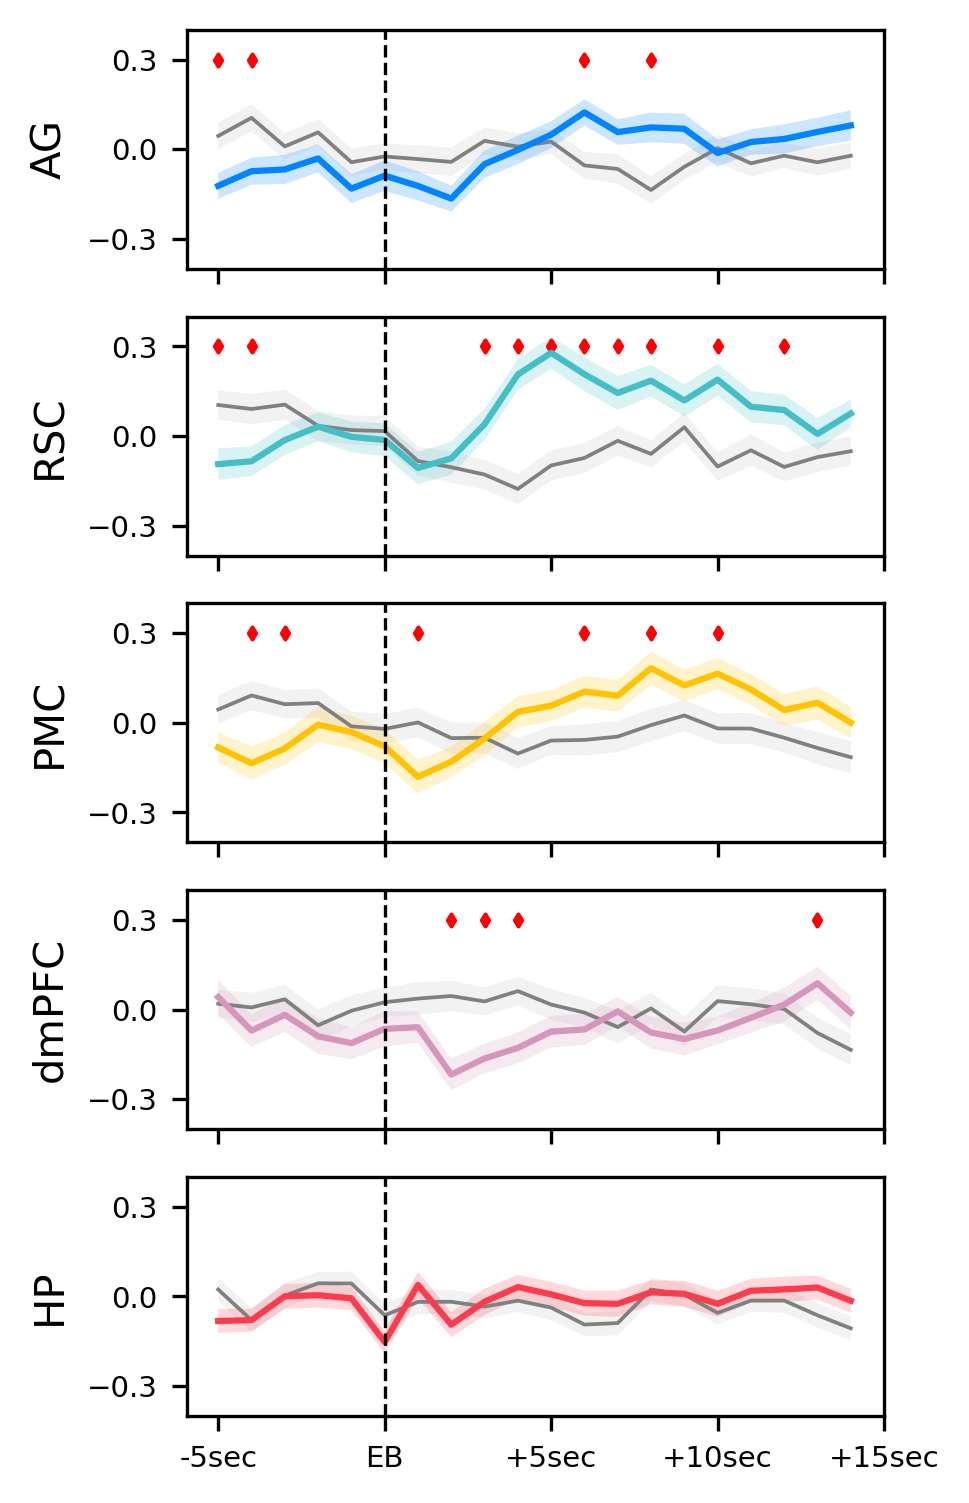

In [191]:
fig, axes = plt.subplots(5,1, figsize=(3, 6), dpi=300, sharex=True)

colors = ["#0084ff", "#44bec7", "#ffc300", "#d696bb", "#fa3c4c"]
for a, ax in enumerate(axes):
    x1 = roi_activity_concat[list(roilist.keys())[a]]
    x2 = roi_activity_random_concat[list(roilist.keys())[a]]
    ax.plot(np.mean(x2,axis=0), color='grey',lw=0.9)
    ax.fill_between(np.linspace(0,19,20), np.mean(x2,axis=0)-sem(roi_activity_random_concat[list(roilist.keys())[a]]), 
                np.mean(x2,axis=0)+sem(roi_activity_random_concat[list(roilist.keys())[a]]),
                color='grey', alpha=0.1, edgecolor=None)
    ax.plot(np.mean(x1,axis=0), color=colors[a])
    ax.fill_between(np.linspace(0,19,20), np.mean(x1,axis=0)-sem(roi_activity_concat[list(roilist.keys())[a]]), 
                    np.mean(x1,axis=0)+sem(roi_activity_concat[list(roilist.keys())[a]]),
                    color=colors[a], alpha=0.2, edgecolor=None)
    for i in range(20):
        if ttest_ind(x1[:,i],x2[:,i])[1]<0.05:
            ax.scatter(i, 0.3, s=4, c='r', marker='d')
    ax.set_xticks([0,5,10,15,20], labelsize=0.5)
    ax.set_xticklabels(["-5sec", "EB","+5sec","+10sec","+15sec"])
    ax.axvline(5, ls='--', lw=0.8, c='black')
    ax.set_ylim(-0.4,0.4)
    ax.set_yticks([-0.3,0,0.3])
    ax.tick_params(labelsize=7)
    ax.set_ylabel(list(roilist.keys())[a])
plt.subplots_adjust(wspace=0.08)

# 3. VLOG

## 3.1. load data

In [223]:
# brain
groups=[2,3,4,5]
group_brain = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        groupsub = f'0{group}0{sub}'
        sub_brain = []
        if (group==2 and sub==1) or (group==3 and sub==1):
            runs = [1]
        else:
            runs = [1,2,3]
        for run in runs:
            fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_VLOG_{run}_sc_dt_sm.nii.gz').get_fdata()
            fiverois = np.zeros((5,len(fmri_data[0,0,0,:])))
            for idx, key in enumerate(list(roilist.keys())):
                epi_parcels = []
                for i in roilist[key]:
                    if key=='HP':
                        epi_parcel = np.nanmean(fmri_data[atlas==i],axis=0).T # time,vox
                    else:
                        epi_parcel = np.nanmean(fmri_data[mask==i],axis=0).T # time,vox
                    epi_parcel = zscore(epi_parcel, axis=0)
                    epi_parcel = np.nan_to_num(epi_parcel)
                    epi_parcels.append(epi_parcel)
                epi_parcels = np.mean(np.array(epi_parcels),axis=0)
                fiverois[idx,:] = epi_parcels
            sub_brain.append(fiverois)
        group_brain[group-2,sub-1] = sub_brain

In [228]:
# event boundaries
group_boundaries = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        groupsub = f'0{group}0{sub}'
        sub_boundaries = []
        if (group==2 and sub==1) or (group==3 and sub==1):
            runs = [1]
        else:
            runs = [1,2,3]
        for run in runs:
            sub_boundaries.append(get_boundary3(group,sub,run))
        group_boundaries[group-2,sub-1] = sub_boundaries

## 3.2. load event boundaries

In [232]:
# boundary effects
w1 = 5
w2 = 15

roi_activity= {}


for roi,roikey in enumerate(list(roilist.keys())):
    group_activity = np.zeros((len(groups),3), dtype='object')
    for group in groups:
        for sub in [1,2,3]:
            sub_activities = []
            if (group==2 and sub==1) or (group==3 and sub==1):
                runs = [1]
            else:
                runs = [1,2,3]
            for run in runs:
                evs = group_boundaries[group-2,sub-1][run-1][:,1]*1.3//1000
                epi = group_brain[group-2,sub-1][run-1][roi]
                prev = 0
                after = 0
                activity = []
                for e,ev in enumerate(evs):
                    ev = int(float(ev))
                    after = ev-w1
                    if len(epi[ev-w1:ev+w2])==20:
                        if after > prev:
                            activity.append(epi[ev-w1:ev+w2])
                    prev=ev+w2
                sub_activities.append(np.array(activity))
            group_activity[group-2,sub-1] = sub_activities
    roi_activity[roikey] = group_activity


In [233]:
# boundary effects - control
w1 = 5
w2 = 15

roi_activity_random= {}


for roi,roikey in enumerate(list(roilist.keys())):
    group_activity = np.zeros((len(groups),3), dtype='object')
    for group in groups:
        for sub in [1,2,3]:
            sub_activities = []
            if (group==2 and sub==1) or (group==3 and sub==1):
                runs = [1]
            else:
                runs = [1,2,3]
            for run in runs:
                nonevs = (np.mean(group_boundaries[group-2,sub-1][run-1],axis=1)*1.3//1000).astype('int')
                epi = group_brain[group-2,sub-1][run-1][roi]
                prev = 0
                after = 0
                activity = []
                for e,ev in enumerate(nonevs):
                    ev = int(float(ev))
                    after = ev-w1
                    if len(epi[ev-w1:ev+w2])==20:
                        if after > prev:
                            activity.append(epi[ev-w1:ev+w2])
                    prev=ev+w2
                sub_activities.append(np.array(activity))
            group_activity[group-2,sub-1] = sub_activities
    roi_activity_random[roikey] = group_activity


In [234]:
roi_activity_concat = {}
roi_activity_random_concat = {}
for roi,roikey in enumerate(list(roilist.keys())):
    for group in groups:
        for sub in [1,2,3]:
            if (group==2 and sub==1) or (group==3 and sub==1): #런 한개
                runs = [1]
            else: #런 여러개
                roi_act = roi_activity[roikey][group-2,sub-1][0]
                roi_actr = roi_activity_random[roikey][group-2,sub-1][0]
                runs = [1,2,3]
            roi_act = np.vstack((roi_act,roi_activity[roikey][group-2,sub-1][0]))
            roi_actr = np.vstack((roi_actr,roi_activity_random[roikey][group-2,sub-1][0]))
            for run in runs[1:]:
                roi_act = np.vstack((roi_act,roi_activity[roikey][group-2,sub-1][run-1]))
                roi_actr = np.vstack((roi_actr,roi_activity_random[roikey][group-2,sub-1][run-1]))

    roi_activity_concat[roikey] = roi_act
    roi_activity_random_concat[roikey] = roi_actr

print(roi_activity_concat[roikey].shape, roi_activity_random_concat[roikey].shape)


(80, 20) (99, 20)


## 3.3. plot event boundaries

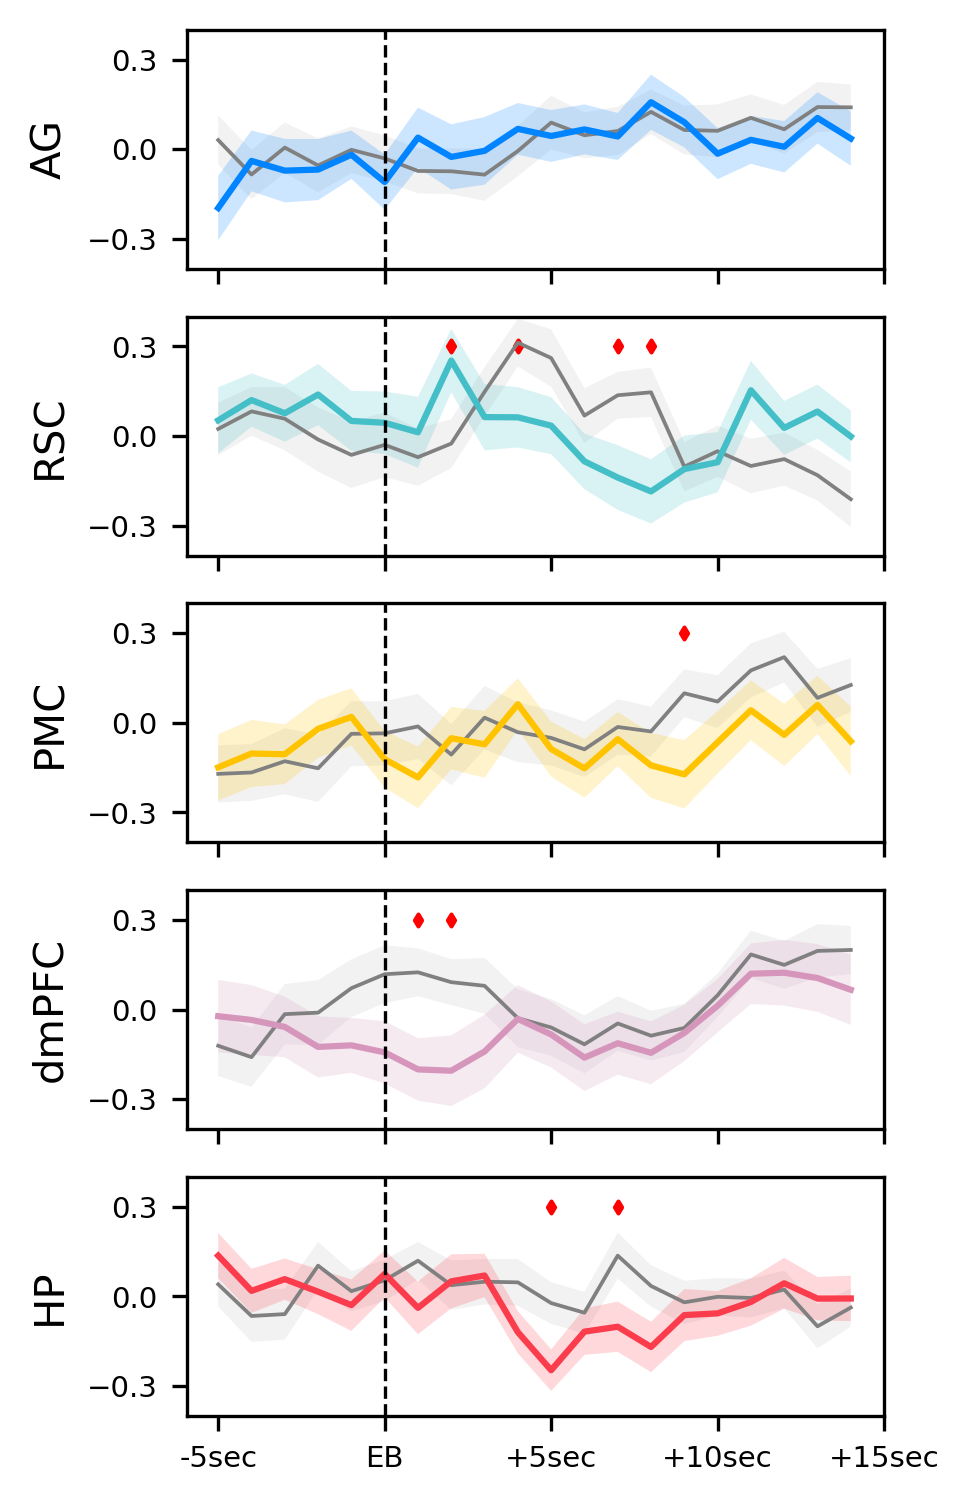

In [237]:
fig, axes = plt.subplots(5,1, figsize=(3, 6), dpi=300, sharex=True)

colors = ["#0084ff", "#44bec7", "#ffc300", "#d696bb", "#fa3c4c"]
for a, ax in enumerate(axes):
    x1 = roi_activity_concat[list(roilist.keys())[a]]
    x2 = roi_activity_random_concat[list(roilist.keys())[a]]
    ax.plot(np.mean(x2,axis=0), color='grey',lw=0.9)
    ax.fill_between(np.linspace(0,19,20), np.mean(x2,axis=0)-sem(roi_activity_random_concat[list(roilist.keys())[a]]), 
                np.mean(x2,axis=0)+sem(roi_activity_random_concat[list(roilist.keys())[a]]),
                color='grey', alpha=0.1, edgecolor=None)
    ax.plot(np.mean(x1,axis=0), color=colors[a])
    ax.fill_between(np.linspace(0,19,20), np.mean(x1,axis=0)-sem(roi_activity_concat[list(roilist.keys())[a]]), 
                    np.mean(x1,axis=0)+sem(roi_activity_concat[list(roilist.keys())[a]]),
                    color=colors[a], alpha=0.2, edgecolor=None)
    for i in range(20):
        if ttest_ind(x1[:,i],x2[:,i])[1]<0.05:
            ax.scatter(i, 0.3, s=4, c='r', marker='d')
    ax.set_xticks([0,5,10,15,20], labelsize=0.5)
    ax.set_xticklabels(["-5sec", "EB","+5sec","+10sec","+15sec"])
    ax.axvline(5, ls='--', lw=0.8, c='black')
    ax.set_ylim(-0.4,0.4)
    ax.set_yticks([-0.3,0,0.3])
    ax.tick_params(labelsize=7)
    ax.set_ylabel(list(roilist.keys())[a])
plt.subplots_adjust(wspace=0.08)